In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml

# Implement neural network from scratch

In [2]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))


def softmax(X):
    """assume that X has shape (batch_size, n_classes)"""
    assert X.ndim == 2, "X must be a 2D array"
    X_exp = np.exp(X - X.max(axis=1, keepdims=True))
    norm_factor = X_exp.sum(axis=1, keepdims=True)
    return X_exp / norm_factor


def cross_entropy(y_hat, y):
    assert y_hat.ndim == 2, "y_hat must be 2D array"
    assert y_hat.shape == y.shape, "y_hat and y must have same shape"
    
    y = y.argmax(axis=1)
    idx0 = range(y_hat.shape[0])
    return -np.mean(np.log(y_hat[idx0, y]))


def weight_initializer(n_inputs, n_units):
    alpha = 1 / np.sqrt(n_inputs)
    return np.random.uniform(low=-alpha, high=alpha, size=(n_inputs, n_units))


def bias_initializer(n_inputs, n_units):
    alpha = 1 / np.sqrt(n_inputs)
    return np.random.uniform(low=-alpha, high=alpha, size=(1, n_units))

In [3]:
def data_generator(X, y, batch_size=32):
    assert X.shape[0] == y.shape[0], "X and y must have the same first shape"
    
    nsamples = X.shape[0]
    idx = np.arange(nsamples)
    np.random.shuffle(idx)
    
    niter = nsamples // batch_size
    for i in range(niter):
        lower = i * batch_size
        upper = (i + 1) * batch_size
        yield X[lower: upper], y[lower: upper]

In [4]:
def feedforward(X, 
                W_1, b_1, 
                W_2, b_2, 
                W_o, b_o):
    Z_1 = X.dot(W_1) + b_1
    H_1 = sigmoid(Z_1)
    
    Z_2 = H_1.dot(W_2) + b_2
    H_2 = sigmoid(Z_2)
    
    Z_o = H_2.dot(W_o) + b_o
    y_hat = softmax(Z_o)
    
    return H_1, H_2, y_hat


def predict(X, 
            W_1, b_1, 
            W_2, b_2, 
            W_o, b_o):
    _, _, y_hat = feedforward(X, W_1, b_1, W_2, b_2, W_o, b_o)
    return y_hat


def backpropagation(X, y, y_hat, W_o, W_2, H_2, H_1):
    delta_o = y_hat - y
    dL_dW_o = H_2.T.dot(delta_o)
    dL_db_o = delta_o.sum(axis=0, keepdims=True)
    
    delta_2 = delta_o.dot(W_o.T) * H_2 * (1 - H_2)
    dL_dW_2 = H_1.T.dot(delta_2)
    dL_db_2 = delta_2.sum(axis=0, keepdims=True)
    
    delta_1 = delta_2.dot(W_2.T) * H_1 * (1 - H_1)
    dL_dW_1 = X.T.dot(delta_1)
    dL_db_1 = delta_1.sum(axis=0, keepdims=True)
    
    return dL_dW_o, dL_db_o, dL_dW_2, dL_db_2, dL_dW_1, dL_db_1


def gradient_descent(X_train, y_train, d_1=64, d_2=64,
                     epochs=10, batch_size=32, learning_rate=0.05):
    
    history = {"loss":[], "accuracy":[], "weight": [], "bias": []}
    
    d = X_train.shape[1]
    k = y_train.shape[1]
    
    # initialize weight and bias
    W_1 = weight_initializer(d, d_1)
    b_1 = bias_initializer(d, d_1)
    
    W_2 = weight_initializer(d_1, d_2)
    b_2 = bias_initializer(d_1, d_2)
    
    W_o = weight_initializer(d_2, k)
    b_o = bias_initializer(d_2, k)
    
    for epoch in range(epochs):
        gen = data_generator(X_train, y_train, batch_size=batch_size)
        
        for X_batch, y_batch in gen:
            H_1, H_2, y_hat = feedforward(X_batch, W_1, b_1, W_2, b_2, W_o, b_o)
            dL_dW_o, dL_db_o, dL_dW_2, dL_db_2, dL_dW_1, dL_db_1 = backpropagation(X_batch, y_batch, y_hat, 
                                                                                   W_o, W_2, H_2, H_1)
            
            W_1 -= learning_rate * dL_dW_1
            b_1 -= learning_rate * dL_db_1
            
            W_2 -= learning_rate * dL_dW_2
            b_2 -= learning_rate * dL_db_2
            
            W_o -= learning_rate * dL_dW_o
            b_o -= learning_rate * dL_db_o
        
        y_hat = predict(X_train, W_1, b_1, W_2, b_2, W_o, b_o)
        loss = cross_entropy(y_hat, y_train)
        acc = accuracy(y_hat, y_train)
        
        history["loss"].append(loss)
        history["accuracy"].append(acc)
        
        history["weight"].append((W_1, W_2, W_o))
        history["bias"].append((b_1, b_2, b_o))
            
        print("epoch %d, loss=%0.5f,  acc=%0.5f" %(epoch, loss, acc))
    
    return history

In [5]:
def onehot_label(y):
    unique_labels = np.unique(y)
    assert unique_labels.min() == 0
    assert unique_labels.max() == unique_labels.shape[0] - 1
    
    k = unique_labels.shape[0]
    n = y.shape[0]
    y_onehot = np.zeros([n, k], dtype="int")
    idx0 = np.arange(n)
    y_onehot[idx0, y] = 1
    return y_onehot

In [6]:
def accuracy(y_hat, y):
    assert y_hat.shape == y.shape, "y_hat and y must have the same shape"
    y_hat = y_hat.argmax(axis=1)
    y = y.argmax(axis=1)
    
    return (y_hat == y).mean()

# Load MNIST data

In [7]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [8]:
X = mnist["data"]
y = mnist["target"].astype(np.int32)

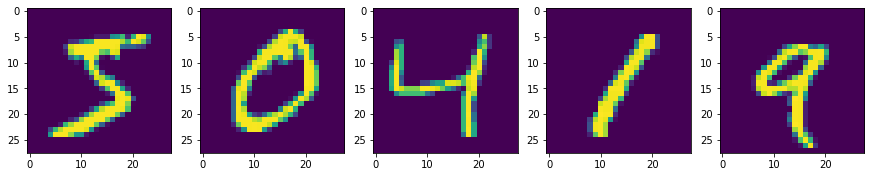

In [9]:
fig, ax = plt.subplots(ncols=5, figsize=(15,5))
for i in range(5): 
    ax[i].imshow(X[i].reshape(28,28))
plt.show()

In [10]:
X = X / 255.0
y = onehot_label(y)

X_train, y_train = X[:60_000], y[:60_000]
X_test, y_test = X[60_000:], y[60_000:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

# Train model

In [11]:
history = gradient_descent(X_train, y_train, epochs=20, batch_size=32, learning_rate=0.05)

epoch 0, loss=0.16892,  acc=0.94832
epoch 1, loss=0.11715,  acc=0.96352
epoch 2, loss=0.08693,  acc=0.97298
epoch 3, loss=0.07692,  acc=0.97577
epoch 4, loss=0.07184,  acc=0.97707
epoch 5, loss=0.06861,  acc=0.97765
epoch 6, loss=0.06620,  acc=0.97817
epoch 7, loss=0.06616,  acc=0.97842
epoch 8, loss=0.04926,  acc=0.98420
epoch 9, loss=0.05253,  acc=0.98292
epoch 10, loss=0.04944,  acc=0.98380
epoch 11, loss=0.04049,  acc=0.98643
epoch 12, loss=0.03733,  acc=0.98777
epoch 13, loss=0.03772,  acc=0.98675
epoch 14, loss=0.03005,  acc=0.98992
epoch 15, loss=0.04028,  acc=0.98622
epoch 16, loss=0.02753,  acc=0.99140
epoch 17, loss=0.02277,  acc=0.99258
epoch 18, loss=0.02250,  acc=0.99275
epoch 19, loss=0.01878,  acc=0.99348


Text(0, 0.5, 'train loss')

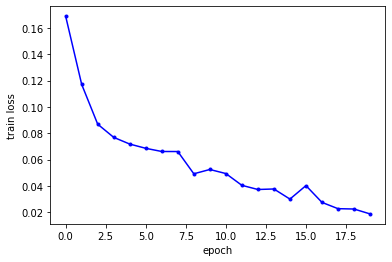

In [12]:
loss_train = history["loss"]
epochs = np.arange(len(loss_train))

plt.plot(epochs, loss_train, "b-", marker=".")
plt.xlabel("epoch")
plt.ylabel("train loss")

In [13]:
W_1, W_2, W_o = history["weight"][-1]
b_1, b_2, b_o = history["bias"][-1]

y_pred_test = predict(X_test, W_1, b_1, W_2, b_2, W_o, b_o)

loss_test = cross_entropy(y_pred_test, y_test)
acc_test = accuracy(y_pred_test, y_test)

print("Test loss: %0.5f" %loss_test)
print("Test accuracy: %0.5f" %acc_test)

Test loss: 0.12865
Test accuracy: 0.97030
